# 1. Import Library

## Import Lib

In [1]:
#Import Lib
import pandas as pd
from bs4 import BeautifulSoup
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from collections import defaultdict, Counter
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud,STOPWORDS

from sklearn.preprocessing import Normalizer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

from sklearn.cluster import KMeans,DBSCAN

color_pal = sns.color_palette()
nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

from keybert import KeyBERT
kw_model = KeyBERT()

from sentence_transformers import SentenceTransformer

model_embedding = SentenceTransformer("all-MiniLM-L6-v2")

# python -m spacy download en_core_web_sm

c:\Users\hoang\anaconda3\envs\GPU_TF\lib\site-packages\tensorflow\python\framework\dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
c:\Users\hoang\anaconda3\envs\GPU_TF\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


# 2. Data Collection

- We use StackExchange Query function to get data. It's an SQL syntax.
```sql
SELECT TOP 25000
  q.Id                     AS QuestionId,
  CONCAT('https://stackoverflow.com/questions/', q.Id) AS QuestionUrl,
  q.Title,
  q.Body,
  q.CreationDate,
  q.Tags,
  q.Score,
  q.ViewCount,
  q.AnswerCount,
  a.Id                     AS AcceptedAnswerId,
  a.Body                   AS AcceptedAnswerBody,
  a.Score                  AS AcceptedAnswerScore
FROM Posts q
  JOIN PostTags pt
    ON pt.PostId = q.Id
  JOIN Tags t
    ON t.Id = pt.TagId
   AND t.TagName = 'nlp'
  LEFT JOIN Posts a 
    ON q.AcceptedAnswerId = a.Id
ORDER BY q.CreationDate DESC;


# 3. Read Data

In [2]:
#Read file
df_post = pd.read_csv("Dataset_Full.csv")

# Remove time from Creation Date
df_post['CreationDate'] = pd.to_datetime(df_post['CreationDate']).dt.date
df_post

#Tag in format <Tag1><Tag2>. Remove < > and join it with ','
df_post['Tags'] = df_post['Tags'].str.findall(r'<([^>]+)>').apply(lambda lst: ','.join(lst))
df_post

,QuestionId,QuestionUrl,Title,Body,CreationDate,Tags,Score,ViewCount,AnswerCount,AcceptedAnswerId,AcceptedAnswerBody,AcceptedAnswerScore
0,79577043,https://stackoverflow.com/questions/79577043,Unsupervised Topic Modeling for Short Event De...,<p>I have a dataset of approximately 750 lines...,2025-04-16,"machine-learning,nlp,topic-modeling",-1,34,1,NaN,NaN,NaN
1,79574001,https://stackoverflow.com/questions/79574001,Is there a way to reuse a heavy service across...,<p>I'm building an Airflow DAG where some of t...,2025-04-14,"nlp,airflow,microservices",1,19,0,NaN,NaN,NaN
2,79572620,https://stackoverflow.com/questions/79572620,How can I link tasks using machine learning / ...,<p>I'm working on an AI model to predict depen...,2025-04-14,"python,machine-learning,nlp,artificial-intelli...",-6,95,0,NaN,NaN,NaN
3,79559702,https://stackoverflow.com/questions/79559702,NameError: name 'init_empty_weights' is not de...,<p>I am trying to set up hugging face locally ...,2025-04-07,"nlp,huggingface-transformers,huggingface",3,629,2,79577000.0,"<p>Try using this version, it should resolve t...",1.0
4,79557354,https://stackoverflow.com/questions/79557354,Sentencepiece not generating models after prep...,<p>So this is the log that I see on the termin...,2025-04-05,"python,nlp,sentencepiece",0,54,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20409,42489,https://stackoverflow.com/questions/42489,"How to implement a ""related"" degree measure al...",<p>I was going to Ask a Question earlier today...,2008-09-03,"algorithm,machine-learning,indexing,nlp,full-t...",8,457,2,42532.0,<p>One such way to implement such an algorithm...,5.0
20410,41424,https://stackoverflow.com/questions/41424,"How do you implement a ""Did you mean""?",<blockquote>\n <p><strong>Possible Duplicate:...,2008-09-03,nlp,118,33225,11,41448.0,<p>Actually what Google does is very much non-...,87.0
20411,36533,https://stackoverflow.com/questions/36533,Vista speech recognition in multiple languages,"<p>my primary language is spanish, but I use a...",2008-08-31,"windows-vista,nlp,speech-recognition,multilingual",3,5661,6,36684.0,"<p>Citation from Vista <a href=""http://blogs.m...",8.0
20412,25332,https://stackoverflow.com/questions/25332,What's a good natural language library to use ...,<p>I'm looking for an existing library to summ...,2008-08-24,"language-agnostic,nlp",14,6494,4,NaN,NaN,NaN


## Some visualisation

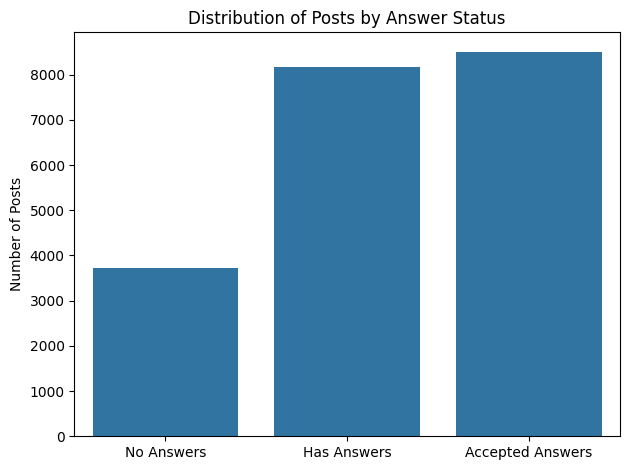

In [3]:
# Distribution posts that no answers, answers, accepted answers

#Prepare some count
no_answers   = (df_post['AnswerCount'] == 0).sum()
has_answers  = ((df_post['AnswerCount'] > 0) & df_post['AcceptedAnswerId'].isna()).sum()
accepted     = df_post['AcceptedAnswerId'].notna().sum()

#Put into dict
dist_answer = {'No Answers':no_answers,'Has Answers':has_answers,'Accepted Answers':accepted}
plt.figure()
sns.barplot(x=dist_answer.keys(), y=dist_answer.values())
plt.title('Distribution of Posts by Answer Status')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

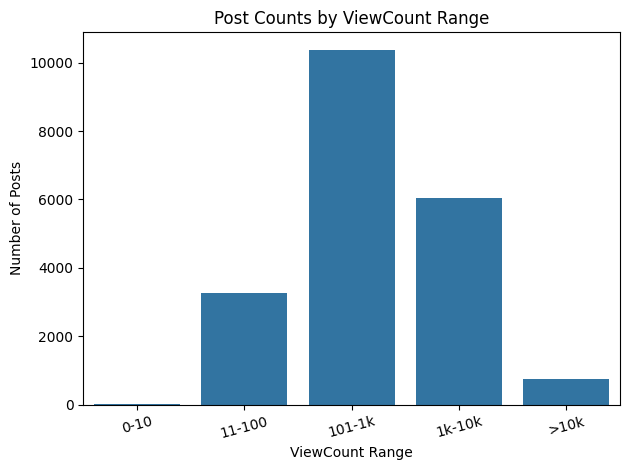

In [4]:
# Create some Range 
bins = [0, 10, 100, 1000, 10000, df_post['ViewCount'].max()]
labels = ['0-10','11-100','101-1k','1k-10k','>10k']

df_post['view_range'] = pd.cut(df_post['ViewCount'], bins=bins, labels=labels, include_lowest=True)

plt.figure()
sns.countplot(data=df_post, x='view_range', order=labels)
plt.title('Post Counts by ViewCount Range')
plt.xlabel('ViewCount Range')
plt.ylabel('Number of Posts')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


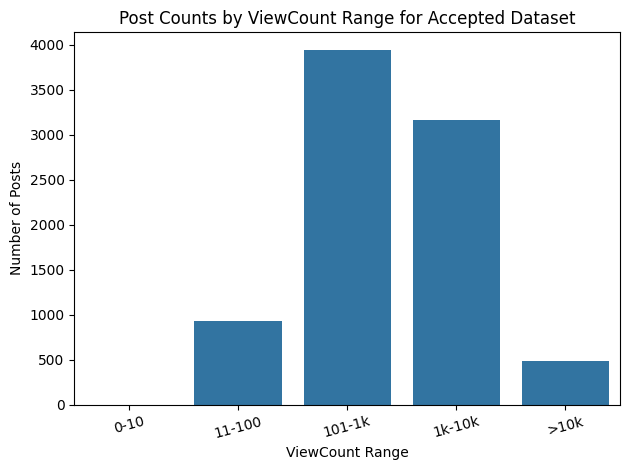

In [5]:
#Filter Data only have accepted answer
df_post_answer = df_post.dropna(subset=['AcceptedAnswerId']).reset_index().drop('index',axis=1)

plt.figure()
sns.countplot(data=df_post_answer, x='view_range', order=labels)
plt.title('Post Counts by ViewCount Range for Accepted Dataset')
plt.xlabel('ViewCount Range')
plt.ylabel('Number of Posts')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

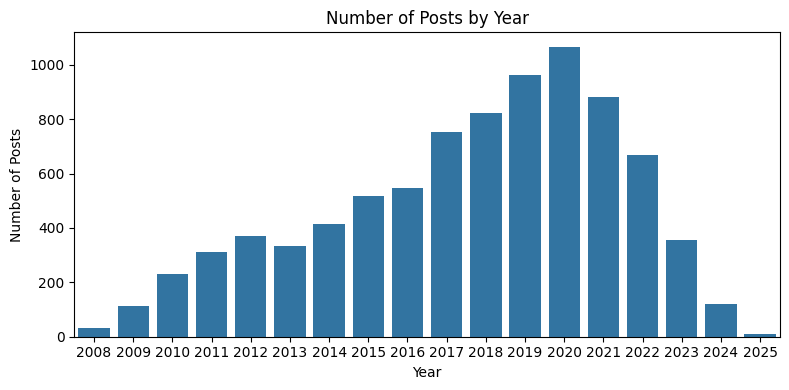

In [6]:
df_post_answer['CreationDate'] = pd.to_datetime(df_post_answer['CreationDate'])
df_post_answer['Year'] = df_post_answer['CreationDate'].dt.year


plt.figure(figsize=(8,4))
sns.countplot(data=df_post_answer,x='Year')
plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

# 4. Preprocess Data

## Function Preparation

In [7]:
# A set of common intensifier words to remove
intensifiers = {
    "very", "really", "extremely", "absolutely", "totally", "highly", "deeply",
    "strongly", "incredibly", "exceptionally", "remarkably", "unbelievably",
    "insanely", "awfully", "horribly", "hugely", "immensely", "overly",
    "particularly", "significantly", "seriously", "tremendously", "wildly",
    "super", "ultra", "crazy", "majorly"
}

def clean_text(text, remove_code=True):
    """
    Clean text:
      1. Removes HTML tags and (optionally) code blocks.
      2. Strips out URLs, punctuation, non-ASCII chars, and intensifiers.
      3. Collapses whitespace to single spaces.
    
    Parameters:
      text (str or any):  Input text to clean; non-string inputs are cast to str.
      remove_code (bool): Whether to strip out <code> and <pre> blocks.
    
    Returns:
      str: The cleaned text.
    """

    # 1. Handle empty or NaN inputs early
    if text is None or text == "" or (isinstance(text, float) and np.isnan(text)):
        return ""
    
    # 2. Cast non‑string inputs (numbers, etc.) to str
    if not isinstance(text, str):
        text = str(text)
    
    # 3. Parse HTML so we can strip tags cleanly
    soup = BeautifulSoup(text, "html.parser")
    
    #    Optionally remove any <code> or <pre> blocks completely
    if remove_code:
        for code_block in soup.find_all(['code', 'pre']):
            code_block.decompose()
    
    # 4. Extract only the visible text
    text = soup.get_text(separator=" ", strip=True)
    
    # 5. Collapse any run of whitespace into a single space
    text = re.sub(r"\s+", " ", text).strip()
    
    # 6. Remove URLs (e.g. http://…)
    text = re.sub(r"http\S+", "", text)
    
    # 7. Strip out common punctuation characters
    text = re.sub(r'[\"\!?\.;,:\-\(\)]', '', text)
    
    # 8. Remove Twitter‑style mentions (e.g. @username)
    text = re.sub(r'@\w+', '', text)
    
    # 9. Remove any non‑ASCII characters
    text = ''.join(char for char in text if ord(char) < 128)
    
    # 10. Remove stray square brackets if any
    text = re.sub(r'\[|\]', '', text)
    
    # 11. Split into words so we can remove intensifiers
    words = text.split()
    
    # 12. Filter out any intensifier words
    words = [w for w in words if w.lower() not in intensifiers]
    
    # 13. Rejoin into a single cleaned string
    return " ".join(words)

In [8]:
def get_code(html_content):
    """
    Extracts all code snippets from an HTML string and returns them concatenated.
    Code is pulled from both <code> and <pre> tags, and each snippet is separated
    by a delimiter for clarity.

    Parameters:
      html_content (str or any):  
          The HTML string to parse. Non-string inputs are cast to str.  
          If None, empty, or NaN, returns an empty string.

    Returns:
      str:  
        - A single string containing all extracted code blocks,  
          separated by "\n---\n" if multiple blocks are found.  
        - An empty string if no code blocks are present.
    """

    # 1. Handle None, empty, or NaN inputs early
    if html_content is None or html_content == "" or (isinstance(html_content, float) and np.isnan(html_content)):
        return ""

    # 2. Ensure we have a string (this covers numeric or other types)
    if not isinstance(html_content, str):
        html_content = str(html_content)

    # 3. Parse the HTML content so we can locate <code> and <pre> tags
    soup = BeautifulSoup(html_content, "html.parser")

    # 4. Find and extract each code block
    code_blocks = []
    for code_tag in soup.find_all(['code', 'pre']):
        # Get the inner text of the tag, stripping leading/trailing whitespace
        snippet = code_tag.get_text(strip=True)
        if snippet:
            code_blocks.append(snippet)
        # Remove this tag from the soup to prevent duplicate extraction
        code_tag.decompose()

    # 5. Join multiple code snippets with a visible delimiter, or return empty if none
    if code_blocks:
        # "\n---\n" separates each snippet for readability
        return "\n---\n".join(code_blocks)
    else:
        return ""

In [9]:
def remove_stopwords(text):
    """
    Remove English stopwords from a piece of text.
    
    Parameters:
      text (str or any):  
        The input text to clean. Non-string inputs will be converted or return an empty string.
    
    Returns:
      str:  
        The text with all English stopwords filtered out, returned as a single space‑joined string.
    """
    
    # 1. Ensure the input is a string; otherwise, we can't tokenize meaningfully.
    if not isinstance(text, str):
        return ""
    
    # 2. Convert text to lowercase to make stopword matching case‑insensitive.
    lower_text = text.lower()
    
    # 3. Tokenize the text into individual words (tokens).
    tokens = word_tokenize(lower_text)
    
    # 4. Load the set of English stopwords from NLTK.
    stop_words = set(stopwords.words('english'))
    
    # 5. Filter out any token that appears in the stopword list.
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # 6. Re‑join the filtered tokens into a single string separated by spaces.
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

In [10]:
def lemma_texts_parallel(texts, batch_size=50, n_process=4) -> pd.Series:
    """
    Lemmatize a list (or Series) of texts using spaCy's parallel processing.

    Parameters:
      texts:  
        The input documents to lemmatize. Non-strings will be cast to str.
      batch_size (int):  
        Number of texts to buffer and process in one batch.
      n_process (int):  
        Number of worker processes to use for parallelism (requires spaCy v3+).

    Returns:
      pd.Series:  
        A pandas Series where each entry is the space-joined lemmas of the corresponding input text.
    """

    # 1. Ensure all inputs are strings (e.g., convert numbers or None to "None")
    texts = [str(t) for t in texts]

    # 2. Prepare a list to collect the lemmatized output
    lemmatized_texts = []

    # 3. Use spaCy's nlp.pipe for efficient, batched, parallel processing
    #    - batch_size controls how many texts are processed at once
    #    - n_process specifies the number of CPU cores to use
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        # 4. Extract the lemma_ for each token in the processed doc
        lemmas = [token.lemma_ for token in doc]
        # 5. Join lemmas into a single string and append to results
        lemmatized_texts.append(" ".join(lemmas))

    # 6. Return results as a pandas Series for easy integration with DataFrames
    return pd.Series(lemmatized_texts)

In [11]:
def wc_generating(data, title):
    """
    Generate and save a word cloud image from a series of text entries.

    Parameters:
      data (pd.Series or list of str):
        An iterable of text strings. Each entry will be concatenated into
        one large corpus for the word cloud.
      title (str):
        The base filename (without extension) for the output PNG image.
        Choose a meaningful title so the saved file is self-documenting.

    Returns:
      None  # The function writes a file to disk but does not return a value.
    """

    # 1. Define the stopwords set to remove very common words from the cloud
    stopwords = set(STOPWORDS)

    # 2. Instantiate the WordCloud object with desired configuration
    wc = WordCloud(
        background_color='white',  # white background for better contrast
        stopwords=stopwords,       # words to exclude
        height=600,                # image height in pixels
        width=400                  # image width in pixels
    )

    # 3. Combine all text entries into a single string
    #    - fillna('') ensures missing values don’t introduce "nan"
    #    - astype(str) converts any non‑string entries to strings
    all_text = " ".join(data.fillna("").astype(str))

    # 4. Generate the word cloud from the aggregated text
    wc.generate(all_text)

    # 5. Save the resulting word cloud to a PNG file
    output_path = f"{title}.png"
    wc.to_file(output_path)

In [12]:
'''Define a function to removing some noise word
This will return a new column in dataframe the text that remove defined noise word'''
noise_words1 = {'word','example','well','output','code','text','string','sentence','model','work','result','see'}
noise_words2 = {'word','example','well','output','code','text','string','sentence','model','work','result','see','one','give','need','list','find','know','look','follow','file','m','etc','two','try','way','use','want','different','two','seem'}
def remove_noise_word(text,noise_words):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    # Remove noise words
    filtered = [word for word in words if word.lower() not in noise_words]
    return " ".join(filtered)

## Clean and get Code

In [13]:
df_post_answer['Question_Code'] = df_post_answer['Body'].apply(get_code)
df_post_answer['Answer_Code'] = df_post_answer['AcceptedAnswerBody'].apply(get_code)

In [14]:
df_post_answer['Title_Clean'] = df_post_answer['Title'].apply(clean_text) 
df_post_answer['Body_Clean'] = df_post_answer['Body'].apply(clean_text)
df_post_answer['AcceptedAnswerBody_Clean'] = df_post_answer['AcceptedAnswerBody'].apply(clean_text)

## Data Prep

### Title + Title Body & Accepted Answer

In [15]:
df_post_answer['combination_text'] = df_post_answer['Title_Clean'] + " " + df_post_answer['Body_Clean'] + " " +  df_post_answer['AcceptedAnswerBody_Clean']
# Remove stop words
df_post_answer['combination_text_clean'] = df_post_answer['combination_text'].apply(remove_stopwords)
#Lemma Text
text = df_post_answer['combination_text_clean'].tolist()
lemma_text = lemma_texts_parallel(text)
df_post_answer['combination_text_clean'] = lemma_text



### Title + Title Body

In [16]:
#Only combine Title and Its Body
df_post_answer['combination_question'] = df_post_answer['Title_Clean'] + " " + df_post_answer['Body_Clean']
# Remove Stopword
df_post_answer['combination_question_clean'] = df_post_answer['combination_question'].apply(remove_stopwords)
#Lemma Text
text = df_post_answer['combination_question_clean'].tolist()
lemma_text = lemma_texts_parallel(text)
df_post_answer['combination_question_clean'] = lemma_text



### Title Only

In [17]:
df_post_answer['Title_Clean'] = df_post_answer['Title_Clean'].apply(remove_stopwords)
#Lemma Text
text = df_post_answer['Title_Clean'].tolist()
lemma_text = lemma_texts_parallel(text)
df_post_answer['Title_Clean'] = lemma_text

# 5. Data Visualisation

## Before Removing Noise

In [18]:
wc_generating(df_post_answer['Title_Clean'],"Title without removing Noise")

## Removing Noise Word 1

In [19]:
df_post_answer['Title_Clean_No_Noise'] = df_post_answer['Title_Clean'].apply(lambda x: remove_noise_word(x, noise_words1))
wc_generating(df_post_answer['Title_Clean_No_Noise'],"Title without Noise 1")

## Removing Noise Word 2

In [20]:
df_post_answer['Title_Clean_No_Noise'] = df_post_answer['Title_Clean'].apply(lambda x: remove_noise_word(x, noise_words2))
wc_generating(df_post_answer['Title_Clean_No_Noise'],"Title without Noise 2")

# 6. Full Implementation 

## Function

In [21]:
#Function for Clustering
def cluster_embedding(dframe,column,model_embedding,cluster_col_name,cluster_type="kmean"):
    embeddings_title = model_embedding.encode(dframe[column].tolist())
    normalizer = Normalizer(norm='l2')               # L2 (unit‑length) normalization
    embeddings_norm = normalizer.fit_transform(embeddings_title)
    dbscan = DBSCAN(eps=0.5,min_samples=5,metric='euclidean')
    k = 10  # or whatever value you want to test
    kmeans = KMeans(n_clusters=k, random_state=42)
    if cluster_type == "kmean":
        cluster_kmean = kmeans.fit_predict(embeddings_norm)
        dframe[cluster_col_name] = cluster_kmean
    elif cluster_type == "dbscan":
        clusters_dbscan = dbscan.fit_predict(embeddings_norm)
        dframe[cluster_col_name] = clusters_dbscan
    
def cluster_embedding(dframe, column, model_embedding, cluster_col_name, cluster_type="kmean"):
    """
    Generate text embeddings for a DataFrame column, normalize them, and assign cluster labels.

    Parameters:
      dframe (pd.DataFrame):
        The DataFrame containing the text data to cluster.
      column (str):
        Name of the column in `dframe` whose values will be embedded and clustered.
      model_embedding:
        A sentence-embedding model with an `.encode()` method.
      cluster_col_name (str):
        The name of the new column in `dframe` where cluster labels will be stored.
      cluster_type (str, optional):
        Type of clustering to apply.  
        - "kmean": use KMeans clustering (default)  
        - "dbscan": use DBSCAN clustering
    """

    # 1. Compute embeddings for each entry in the specified column
    texts = dframe[column].astype(str).tolist()
    embeddings = model_embedding.encode(texts)

    # 2. Normalize embeddings to unit length (L2 normalization)
    normalizer = Normalizer(norm='l2')
    embeddings_norm = normalizer.fit_transform(embeddings)

    # 3. Prepare clustering algorithms
    #    - DBSCAN for density‑based clusters
    dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
    #    - KMeans with a fixed number of clusters (tune `k` as needed)
    k = 10
    kmeans = KMeans(n_clusters=k, random_state=42)

    # 4. Fit and assign cluster labels based on the chosen method
    if cluster_type.lower() == "kmean":
        labels = kmeans.fit_predict(embeddings_norm)
    elif cluster_type.lower() == "dbscan":
        labels = dbscan.fit_predict(embeddings_norm)

    # 5. Store the cluster labels in the DataFrame
    dframe[cluster_col_name] = labels        

In [22]:
#Function 
def extract_keyword(text):
    # Extract keywords using KeyBert; returns list of (keyword, score)
    keyword_tuples = kw_model.extract_keywords(
        text, 
        keyphrase_ngram_range=(1, 2),
        use_maxsum=True, 
        nr_candidates=10, 
        top_n=5
    )
    # Extract only the keyword strings from the tuples
    keywords = [kw for kw, score in keyword_tuples]
    return ",".join(keywords)

In [23]:
def get_frequency(data, min_support=0.01):
    """
    Get frequent itemsets from a list of transactions using the Apriori algorithm.

    Parameters:
      data (iterable of lists):  
        Each entry is a list of items for one transaction.
      min_support (float):  
        Minimum support threshold for an itemset to be considered frequent.

    Returns:
      pd.DataFrame:  
        DataFrame of frequent itemsets with columns:
          - 'support': proportion of transactions containing the itemset
          - 'itemsets': the frozenset of items in that itemset
    """
    # 1. Initialize the TransactionEncoder, which will one-hot encode our item lists
    te = TransactionEncoder()
    
    # 2. Fit the encoder to our data and transform into a boolean array
    #    shape = (n_transactions, n_unique_items)
    item_te = te.fit(data).transform(data)
    
    # 3. Convert the boolean array to a DataFrame with item names as columns
    df_items_1hot = pd.DataFrame(item_te, columns=te.columns_)
    
    # 4. Run the Apriori algorithm to find all itemsets with support >= min_support
    frequent_itemsets_apriori = apriori(
        df_items_1hot,
        min_support=min_support,
        use_colnames=True
    )
    
    return frequent_itemsets_apriori


def category_frequency(data, keyword_col, cluster_col, min_support):
    """
    Compute frequent keyword patterns within each cluster category.

    Parameters:
      data (pd.DataFrame):  
        DataFrame containing at least two columns:
          - keyword_col: comma-separated keywords per row
          - cluster_col: categorical labels to group by
      keyword_col (str):  
        Name of the column containing comma-separated keywords.
      cluster_col (str):  
        Name of the column containing cluster/category labels.
      min_support (float):  
        Minimum support threshold for frequent pattern mining.

    Returns:
      pd.DataFrame:  
        Aggregated DataFrame of frequent patterns across all clusters with columns:
          - 'score': support of the pattern (renamed from 'support')
          - 'pattern': frozenset of keywords composing the itemset
          - 'cluster': cluster label the pattern belongs to
    """
    # 1. Select only the keyword and cluster columns, replace empty strings with NaN, then drop those rows
    for_category = (
        data[[keyword_col, cluster_col]]
        .replace('', np.nan)
        .dropna(axis=0)
    )
    
    # 2. Split the comma-separated keyword strings into lists
    for_category['keywords_list'] = for_category[keyword_col].str.split(',')
    
    # 3. Identify unique cluster labels and sort them
    cluster_group = np.sort(for_category[cluster_col].unique())
    
    # 4. Collect per-cluster frequent pattern DataFrames in a list
    pattern_dfs = []
    
    for cluster in cluster_group:
        # 4a. Extract only the keyword lists for the given cluster
        cluster_data = for_category.loc[
            for_category[cluster_col] == cluster,
            'keywords_list'
        ]
        
        # 4b. Mine frequent patterns for this cluster
        pattern = get_frequency(cluster_data, min_support)
        
        # 4c. Keep only patterns of length > 1
        pattern = pattern.loc[pattern['itemsets'].apply(lambda x: len(x) > 1)].copy()
        
        # 4d. Annotate the pattern DataFrame with the cluster label
        pattern['cluster'] = cluster
        
        # 4e. Add to our list
        pattern_dfs.append(pattern)
    
    # 5. Concatenate all cluster-specific results into a single DataFrame
    frequency_df = pd.concat(pattern_dfs, ignore_index=True)
    
    # 6. Rename columns for clarity/export
    frequency_df.rename(
        columns={
            'support': 'score',    # pattern frequency -> 'score'
            'itemsets': 'pattern'  # itemset -> 'pattern'
        },
        inplace=True
    )
    
    return frequency_df

## 6.1 Full Implementation for Title only

### Get cluster

In [24]:
cluster_embedding(df_post_answer,'Title_Clean_No_Noise',model_embedding,cluster_col_name="title_cluster")

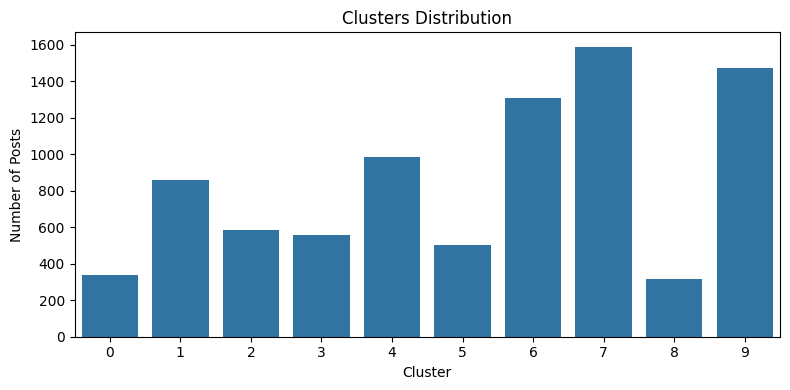

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_post_answer,x="title_cluster")
plt.title('Clusters Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

### Extract Keyword

In [26]:
df_post_answer['keywords_fromBert'] = df_post_answer['Title_Clean_No_Noise'].apply(extract_keyword)

### Frequent Pattern Mining

In [27]:
frequency_questions = category_frequency(df_post_answer,keyword_col="keywords_fromBert",cluster_col="title_cluster",min_support=0.005)

In [28]:
frequency_questions
top2 = (
    frequency_questions
    .sort_values("score", ascending=False)
    .groupby("cluster", as_index=False)
    .head(2)
)
top2

,score,pattern,cluster
197,0.100000,"(corenlp, stanford)",3
617,0.098305,"(gensim, word2vec)",8
259,0.087037,"(stanford, parser)",3
423,0.063918,"(entity, spacy)",5
563,0.061017,"(gensim, doc2vec)",8
446,0.059794,"(ner, spacy)",5
120,0.055215,"(nltk, python)",1
729,0.038999,"(natural, language)",9
112,0.035583,"(python, nlp)",1
738,0.030169,"(natural language, natural)",9


## Checking each cluster

### Cluster 0: Tokenising Text

In [29]:
frequency_questions.loc[frequency_questions['cluster']==0].sort_values("score",ascending=False)

,score,pattern,cluster
33,0.028939,"(tokenizer, keras)",0
45,0.022508,"(tokenizer, nltk)",0
62,0.022508,"(token, spacy)",0
53,0.022508,"(tokenize, python)",0
65,0.019293,"(tokenizer, spacy)",0
...,...,...,...
30,0.006431,"(tokenizer, issue)",0
29,0.006431,"(index, token)",0
27,0.006431,"(token, huggingface)",0
26,0.006431,"(huggingface tokenizer, huggingface)",0


### Cluster 1: Using NLTK Library

In [30]:
frequency_questions.loc[frequency_questions['cluster']==1].sort_values("score",ascending=False)

,score,pattern,cluster
120,0.055215,"(nltk, python)",1
112,0.035583,"(python, nlp)",1
92,0.025767,"(corpus, nltk)",1
130,0.018405,"(nltk, wordnet)",1
135,0.017178,"(python, python nltk)",1
104,0.014724,"(nltk, extract)",1
119,0.014724,"(nltk, pos)",1
87,0.013497,"(chunk, nltk)",1
109,0.013497,"(nltk, language)",1
121,0.012270,"(nltk, python nltk)",1


### Cluster 2: Handling Error in NLP Task

In [31]:
frequency_questions.loc[frequency_questions['cluster']==2].sort_values("score",ascending=False)

,score,pattern,cluster
142,0.017762,"(object, attributeerror)",2
152,0.012433,"(gensim, error)",2
150,0.010657,"(nameerror, define)",2
154,0.010657,"(error, python)",2
139,0.008881,"(attribute, attributeerror)",2
170,0.008881,"(module, modulenotfounderror module)",2
173,0.007105,"(object, str)",2
172,0.007105,"(number sample, variable inconsistent)",2
171,0.007105,"(modulenotfounderror, modulenotfounderror module)",2
169,0.007105,"(module, modulenotfounderror)",2


### Cluster 3: Using Stanford Library

In [32]:
frequency_questions.loc[frequency_questions['cluster']==3].sort_values("score",ascending=False)

,score,pattern,cluster
197,0.100000,"(corenlp, stanford)",3
259,0.087037,"(stanford, parser)",3
242,0.070370,"(stanford, nlp)",3
268,0.033333,"(tag, pos)",3
210,0.029630,"(dependency, stanford)",3
...,...,...,...
228,0.005556,"(format, tree)",3
227,0.005556,"(stanford, format)",3
226,0.005556,"(relation, extraction)",3
225,0.005556,"(nlp, extraction)",3


### Cluster 4: Preprocessing Text in Python

In [33]:
frequency_questions.loc[frequency_questions['cluster']==4].sort_values("score",ascending=False)

,score,pattern,cluster
347,0.026596,"(extract, python)",4
376,0.025532,"(python, remove)",4
365,0.024468,"(panda dataframe, panda)",4
339,0.019149,"(datum, python)",4
342,0.013830,"(dictionary, python)",4
...,...,...,...
360,0.005319,"(python, long)",4
361,0.005319,"(loop, python)",4
363,0.005319,"(python, multiple)",4
364,0.005319,"(number, python)",4


### Cluster 5: Using Spacy Library

In [34]:
frequency_questions.loc[frequency_questions['cluster']==5].sort_values("score",ascending=False)

,score,pattern,cluster
423,0.063918,"(entity, spacy)",5
446,0.059794,"(ner, spacy)",5
444,0.039175,"(matcher, spacy)",5
400,0.035052,"(custom, spacy)",5
485,0.035052,"(training, spacy)",5
...,...,...,...
474,0.006186,"(set, spacy)",5
475,0.006186,"(spacy, similar)",5
410,0.006186,"(dictionary, spacy)",5
408,0.006186,"(dependency, parsing)",5


### Cluster 6: BERT & Hugging Face Application

In [35]:
frequency_questions.loc[frequency_questions['cluster']==6].sort_values("score",ascending=False)

,score,pattern,cluster
512,0.011523,"(transformer, huggingface)",6
511,0.009053,"(hug, face)",6
510,0.007407,"(training, datum)",6
507,0.006584,"(baye, naive)",6
513,0.006584,"(learn, scikit)",6
508,0.005761,"(bert, embedding)",6
509,0.005761,"(bert, huggingface)",6
514,0.005761,"(rnn, pytorch)",6


### Cluster 7: Text Similarity

In [36]:
frequency_questions.loc[frequency_questions['cluster']==7].sort_values("score",ascending=False)

,score,pattern,cluster
523,0.011211,"(regular, expression)",7
520,0.008221,"(similarity, cosine)",7
524,0.008221,"(tag, pos)",7
516,0.007474,"(similarity, calculate)",7
519,0.007474,"(cosine, cosine similarity)",7
525,0.007474,"(regular expression, regular)",7
517,0.006726,"(calculate cosine, similarity)",7
518,0.005979,"(character, remove)",7
522,0.005979,"(datum, extract)",7
515,0.005232,"(calculate cosine, calculate)",7


### Cluster 8: Word Embedding

In [37]:
frequency_questions.loc[frequency_questions['cluster']==8].sort_values("score",ascending=False)

,score,pattern,cluster
617,0.098305,"(gensim, word2vec)",8
563,0.061017,"(gensim, doc2vec)",8
682,0.050847,"(word2vec, vector)",8
661,0.040678,"(similarity, word2vec)",8
574,0.030508,"(similarity, doc2vec)",8
...,...,...,...
619,0.006780,"(gensim, word2vec python)",8
618,0.006780,"(word2vec object, gensim)",8
559,0.006780,"(doc2vec vector, doc2vec)",8
616,0.006780,"(gensim, weight)",8


### Cluster 9: NLP Application

In [38]:
frequency_questions.loc[frequency_questions['cluster']==9].sort_values("score",ascending=False)

,score,pattern,cluster
729,0.038999,"(natural, language)",9
738,0.030169,"(natural language, natural)",9
739,0.027962,"(processing, natural)",9
732,0.027962,"(natural, language processing)",9
721,0.020603,"(analysis, sentiment analysis)",9
730,0.017660,"(natural language, language)",9
734,0.017660,"(processing, language processing)",9
750,0.016924,"(processing, natural, language processing)",9
725,0.015453,"(recognition, entity)",9
747,0.015453,"(natural language, natural, language)",9


## Put naming back to Dataset

In [39]:
category_name = {
    0:"Tokenising Text",
    1:"Using NLTK Library",
    2:"Handling Error in NLP Task",
    3:"Using Stanford Library",
    4:"Preprocessing Text in Python",
    5:"Using Spacy Library",
    6:"BERT & Hugging Face Application",
    7:"Text Similarity",
    8:"Word Embedding",
    9:"NLP Application",
}


df_post_answer['category_name'] = df_post_answer['title_cluster'].map(category_name)
df_post_answer


,QuestionId,QuestionUrl,Title,Body,CreationDate,Tags,Score,ViewCount,AnswerCount,AcceptedAnswerId,...,Body_Clean,AcceptedAnswerBody_Clean,combination_text,combination_text_clean,combination_question,combination_question_clean,Title_Clean_No_Noise,title_cluster,keywords_fromBert,category_name
0,79559702,https://stackoverflow.com/questions/79559702,NameError: name 'init_empty_weights' is not de...,<p>I am trying to set up hugging face locally ...,2025-04-07,"nlp,huggingface-transformers,huggingface",3,629,2,79577000.0,...,I am trying to set up hugging face locally and...,Try using this version it should resolve the i...,NameError name 'init_empty_weights' is not def...,nameerror name ' init_empty_weight ' define us...,NameError name 'init_empty_weights' is not def...,nameerror name ' init_empty_weight ' define us...,nameerror name initemptyweight define hug face,2,"define,face,initemptyweight define,nameerror,d...",Handling Error in NLP Task
1,79549787,https://stackoverflow.com/questions/79549787,Why does Presidio with spacy nlp engine not re...,<p>I'm using spaCy with the pl_core_news_lg mo...,2025-04-02,"python,nlp,spacy,presidio",0,97,1,79552218.0,...,I'm using spaCy with the pl_core_news_lg model...,The configuration file is missing the 'labels_...,Why does Presidio with spacy nlp engine not re...,presidio spacy nlp engine recognize organizati...,Why does Presidio with spacy nlp engine not re...,presidio spacy nlp engine recognize organizati...,presidio spacy nlp engine recognize organizati...,5,"pesel,spacy,recognize organization,presidio sp...",Using Spacy Library
2,79548202,https://stackoverflow.com/questions/79548202,GPT-2 and other models from huggingface -100 l...,<p>I understand the -100 label id is used so t...,2025-04-01,"nlp,huggingface-transformers,pre-trained-model",0,54,1,79551169.0,...,I understand the 100 label id is used so that ...,The author of the tutorial you mentioned sets ...,GPT2 and other models from huggingface 100 lab...,gpt2 model huggingface 100 label index trainin...,GPT2 and other models from huggingface 100 lab...,gpt2 model huggingface 100 label index trainin...,gpt2 huggingface 100 label index training inst...,6,"label,index training,huggingface 100,pad token...",BERT & Hugging Face Application
3,79523269,https://stackoverflow.com/questions/79523269,Trouble getting importing gensim to work in colab,<p>I am trying to import gensim into colab.</p...,2025-03-20,"numpy,nlp,dependencies,google-colaboratory,gensim",0,209,1,79523777.0,...,I am trying to import gensim into colab I get ...,You have to restart the session for the underl...,Trouble getting importing gensim to work in co...,trouble getting import gensim work colab try i...,Trouble getting importing gensim to work in co...,trouble getting import gensim work colab try i...,trouble getting import gensim colab,2,"getting,trouble,colab,gensim,getting import",Handling Error in NLP Task
4,79501178,https://stackoverflow.com/questions/79501178,Store images instead of showing in a server,<p>I am running the code found on this <a href...,2025-03-11,"python,nlp,large-language-model",0,39,1,79501337.0,...,I am running the code found on this site in my...,I can't test it but I checked source code and ...,Store images instead of showing in a server I ...,store image instead show server run code find ...,Store images instead of showing in a server I ...,store image instead show server run code find ...,store image instead show server,6,"instead,store,image,server,store image",BERT & Hugging Face Application
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8505,62328,https://stackoverflow.com/questions/62328,Is there an algorithm that tells the semantic ...,"<p>input: phrase 1, phrase 2</p>\n\n<p>output:...",2008-09-15,"algorithm,nlp,semantics",65,49906,11,63076.0,...,input phrase 1 phrase 2 output semantic simila...,You might want to check out this paper Sentenc...,Is there an algorithm that tells the semantic ...,

## 6.2 Full Process for: Title + Title Body

In [40]:
# df_post_answer['combination_question_clean_no_noise'] = df_post_answer['combination_question_clean'].apply(lambda x: remove_noise_word(x, noise_words2))
# cluster_embedding(df_post_answer,'combination_question_clean_no_noise',model_embedding,cluster_col_name="title_body_cluster")

In [41]:
# df_post_answer['title_body_keywords_fromBert'] = df_post_answer['combination_question_clean_no_noise'].apply(extract_keyword)

In [42]:
# frequency_questions_body = category_frequency(df_post_answer,keyword_col="title_body_keywords_fromBert",cluster_col="title_body_cluster",min_support=0.005)

# 7 Result

In [43]:
top10 = (
    df_post_answer[['Title','Title_Clean','Tags','title_cluster','category_name','QuestionUrl','Year']]
    .sort_values("Year", ascending=False)
    .groupby("title_cluster", as_index=False)
    .head(10)
).sort_values("title_cluster")
top10

,Title,Title_Clean,Tags,title_cluster,category_name,QuestionUrl,Year
19,Normalization of token embeddings in BERT enco...,normalization token embedding bert encoder block,"nlp,normalization,bert-language-model,attentio...",0,Tokenising Text,https://stackoverflow.com/questions/79178041,2024
126,How to Find Positional embeddings from BARTTok...,find positional embedding barttokenizer,"pytorch,nlp,huggingface-transformers,summariza...",0,Tokenising Text,https://stackoverflow.com/questions/77800331,2024
114,Why token embedding different from the embeddi...,token embed different embed bartforconditional...,"machine-learning,pytorch,nlp,huggingface-trans...",0,Tokenising Text,https://stackoverflow.com/questions/77906649,2024
27,How can I adjust the performance of tokenizer?,adjust performance tokenizer,"nlp,huggingface-transformers,huggingface,huggi...",0,Tokenising Text,https://stackoverflow.com/questions/79100835,2024
20,How to convert character indices to BERT token...,convert character indices bert token index,"python,nlp,dataset,large-language-model,bert-l...",0,Tokenising Text,https://stackoverflow.com/questions/79173053,2024
...,...,...,...,...,...,...,...
25,How to derive attributes/labels from short pla...,derive attribute / label short plain text desc...,"nlp,artificial-intelligence,large-language-mod...",9,NLP Application,https://stackoverflow.com/questions/79111733,2024
71,FastText language_identification in R returns ...,fasttext language_identification r return many...,"r,nlp,fasttext,language-detection",9,NLP Application,https://stackoverflow.com/questions/78443980,2024
93,"How to detect if two sentences are simmilar, n...",detect two sentence simmilar mean syllable / word,"search,nlp,full-text-search,similarity,sentenc...",9,NLP Application,https://stackoverflow.com/questions/78241665,2024
75,Performance of textSimilarity() from R's text ...,performance textsimilarity r 's text library,"r,performance,nlp,huggingface-transformers",9,NLP Application,https://stackoverflow.com/questions/78393709,2024


In [44]:
top2 = (
    df_post_answer[['Title','Title_Clean','Tags','title_cluster','category_name','QuestionUrl','Year']]
    .sort_values("Year", ascending=False)
    .groupby("title_cluster", as_index=False)
    .head(2)
)
top2

,Title,Title_Clean,Tags,title_cluster,category_name,QuestionUrl,Year
0,NameError: name 'init_empty_weights' is not de...,nameerror name ' init_empty_weight ' define us...,"nlp,huggingface-transformers,huggingface",2,Handling Error in NLP Task,https://stackoverflow.com/questions/79559702,2025
2,GPT-2 and other models from huggingface -100 l...,gpt2 model huggingface 100 label index trainin...,"nlp,huggingface-transformers,pre-trained-model",6,BERT & Hugging Face Application,https://stackoverflow.com/questions/79548202,2025
3,Trouble getting importing gensim to work in colab,trouble getting import gensim work colab,"numpy,nlp,dependencies,google-colaboratory,gensim",2,Handling Error in NLP Task,https://stackoverflow.com/questions/79523269,2025
4,Store images instead of showing in a server,store image instead show server,"python,nlp,large-language-model",6,BERT & Hugging Face Application,https://stackoverflow.com/questions/79501178,2025
5,Presidio with Langchain Experimental does not ...,presidio langchain experimental detect polish ...,"python,nlp,spacy,langchain,presidio",9,NLP Application,https://stackoverflow.com/questions/79482283,2025
6,OpenNLP POSTaggerME and ChunkerME synergy,opennlp postaggerme chunkerme synergy,"nlp,opennlp",3,Using Stanford Library,https://stackoverflow.com/questions/79459888,2025
1,Why does Presidio with spacy nlp engine not re...,presidio spacy nlp engine recognize organizati...,"python,nlp,spacy,presidio",5,Using Spacy Library,https://stackoverflow.com/questions/79549787,2025
92,Get previous sentence while using SpaCy matcher,get previous sentence use spacy matcher,"python,nlp,spacy",5,Using Spacy Library,https://stackoverflow.com/questions/78258373,2024
87,What's inside inner vertices in Word2Vec Hiera...,'s inside inner vertex word2vec hierarchical s...,"machine-learning,nlp,word2vec,hierarchical,sof...",8,Word Embedding,https://stackoverflow.com/questions/78285447,2024
89,What is the best function/stage to use tokeniz...,good function / stage use tokenizer pytorch 's...,"pytorch,nlp",0,Tokenising Text,https://stackoverflow.com/questions/78284866,2024
